# Hotel Review Classification

### Team 1: Renetta Nelson, Jacqueline Urenda

### June 26, 2023

## Importing Libraries

In [39]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import csv
import time
import random
from collections import OrderedDict
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import nltk
import random
import os
import warnings
warnings.filterwarnings("ignore")

py.init_notebook_mode(connected=True)


from nltk.stem import WordNetLemmatizer
from random import randint
from textblob import TextBlob
from time import sleep

color = sns.color_palette()
%matplotlib inline


from collections import Counter, defaultdict
from string import punctuation
from nltk.corpus import stopwords
from nltk.metrics import ConfusionMatrix


from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.svm import LinearSVC
from sklearn import metrics


from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator


In [6]:
#import nltk
#nltk.download('wordnet')

## Loading Cleaned Data into a DataFrame

### Loading the "hotels_df.csv" file 
 In case of "Access Denied" during web scraping

In [7]:
dir_path = "C:/Users/nelso/Desktop"

os.chdir(dir_path)

hotels_df = pd.read_csv('hotels_df.csv')

hotels_df = hotels_df.iloc[: , 1:]

In [8]:
hotels_df.head()


,names,num_reviews,ratings,review_title,review_rating,review_summary
0,Bahia Resort Hotel,6370,4.5,"['Great stay!', 'Outstanding large boutique re...","[4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, ...",['We had a great stay at the Bahia Resort in S...
1,Manchester Grand Hyatt San Diego,12646,4.5,"['Excellent hotel', 'Great Stay Near Conventio...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",['The price is very reasonable and the view fr...
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5,"['Great location near Seaport Village, USS Mid...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...","['Great location near Seaport Village, USS Mid..."
3,San Diego Mission Bay Resort,1365,4.0,"['Beautiful Place to Stay', 'Excellent from st...","[4.0, 4.0, 4.5, 4.0, 4.0, 3.5, 5.0, 4.5, 4.5, ...","['Hotel was clean, rooms are large and balconi..."
4,San Diego Marriott La Jolla,1505,4.5,['Probably won’t stay at this location again.'...,"[4.5, 4.5, 4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.0, ...",['Room was nice enough but the lack of houseke...


## Exploratory Data Analysis

### Plotting the Distribution of Hotel Ratings

In [9]:
color = sns.color_palette()
%matplotlib inline
fig = px.histogram(hotels_df, x="ratings",  width=800, height=400)
fig.update_traces(marker_color="pink",marker_line_color='orchid',
                  marker_line_width=1.5)
fig.update_layout(title_text='Hotel Ratings Distribution')
fig.show()

 - There are less hotels with a ratings score of less than 3. Majority of hotel guests that have written a review have a positive experience. 

## Data Preparation

### Functions

In [10]:
#punctuation
punctuation = set(punctuation) 
tw_punct = punctuation - {"#"}

#stopwords and null removal

sw = stopwords.words("english")
sw = sw + ['nan']

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")


# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])    

# Function to remove stop words:

def remove_stop(tokens) :
    

    return[t for t in tokens if t not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    return([item.lower() for item in whitespace_pattern.split(text)])
    

full_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]


def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

### Descriptive Statistics

- Needs to be Completed

### Tokenization

In [11]:

hotels_df['title_tokens']= hotels_df['review_title'].apply(prepare, pipeline=full_pipeline)
hotels_df['summary_tokens']= hotels_df['review_summary'].apply(prepare, pipeline=full_pipeline)

hotels_df.head()

,names,num_reviews,ratings,review_title,review_rating,review_summary,title_tokens,summary_tokens
0,Bahia Resort Hotel,6370,4.5,"['Great stay!', 'Outstanding large boutique re...","[4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, ...",['We had a great stay at the Bahia Resort in S...,"[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ..."
1,Manchester Grand Hyatt San Diego,12646,4.5,"['Excellent hotel', 'Great Stay Near Conventio...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",['The price is very reasonable and the view fr...,"[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,..."
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5,"['Great location near Seaport Village, USS Mid...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...","['Great location near Seaport Village, USS Mid...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, uss,..."
3,San Diego Mission Bay Resort,1365,4.0,"['Beautiful Place to Stay', 'Excellent from st...","[4.0, 4.0, 4.5, 4.0, 4.0, 3.5, 5.0, 4.5, 4.5, ...","['Hotel was clean, rooms are large and balconi...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, rooms, large, balconies, provid..."
4,San Diego Marriott La Jolla,1505,4.5,['Probably won’t stay at this location again.'...,"[4.5, 4.5, 4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.0, ...",['Room was nice enough but the lack of houseke...,"[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib..."


### Lemmatization

In [12]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text

hotels_df['title_lemma'] = hotels_df['title_tokens'].apply(lambda x: word_lemmatizer(x))
hotels_df['summary_lemma'] = hotels_df['summary_tokens'].apply(lambda x: word_lemmatizer(x))

hotels_df.head()

,names,num_reviews,ratings,review_title,review_rating,review_summary,title_tokens,summary_tokens,title_lemma,summary_lemma
0,Bahia Resort Hotel,6370,4.5,"['Great stay!', 'Outstanding large boutique re...","[4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, ...",['We had a great stay at the Bahia Resort in S...,"[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...","[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ..."
1,Manchester Grand Hyatt San Diego,12646,4.5,"['Excellent hotel', 'Great Stay Near Conventio...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",['The price is very reasonable and the view fr...,"[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...","[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,..."
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5,"['Great location near Seaport Village, USS Mid...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...","['Great location near Seaport Village, USS Mid...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, us, ...","[great, location, near, seaport, village, us, ..."
3,San Diego Mission Bay Resort,1365,4.0,"['Beautiful Place to Stay', 'Excellent from st...","[4.0, 4.0, 4.5, 4.0, 4.0, 3.5, 5.0, 4.5, 4.5, ...","['Hotel was clean, rooms are large and balconi...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, rooms, large, balconies, provid...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, room, large, balcony, provide, ..."
4,San Diego Marriott La Jolla,1505,4.5,['Probably won’t stay at this location again.'...,"[4.5, 4.5, 4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.0, ...",['Room was nice enough but the lack of houseke...,"[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib...","[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib..."


## Sentiment Analysis

### Calculating Sentiment

In [13]:
#converting lemmatized data into string

hotels_df['title_lemma_str'] = [' '.join(map(str,l)) for l in hotels_df['title_lemma']]
hotels_df['summary_lemma_str'] = [' '.join(map(str,l)) for l in hotels_df['summary_lemma']]


hotels_df.head()

,names,num_reviews,ratings,review_title,review_rating,review_summary,title_tokens,summary_tokens,title_lemma,summary_lemma,title_lemma_str,summary_lemma_str
0,Bahia Resort Hotel,6370,4.5,"['Great stay!', 'Outstanding large boutique re...","[4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, ...",['We had a great stay at the Bahia Resort in S...,"[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...","[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...",great stay outstanding large boutique resort g...,great stay bahia resort san diego ben front de...
1,Manchester Grand Hyatt San Diego,12646,4.5,"['Excellent hotel', 'Great Stay Near Conventio...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",['The price is very reasonable and the view fr...,"[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...","[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...",excellent hotel great stay near convention cen...,price reasonable view window great easy fast c...
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5,"['Great location near Seaport Village, USS Mid...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...","['Great location near Seaport Village, USS Mid...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, us, ...","[great, location, near, seaport, village, us, ...",great location near seaport village us midway ...,great location near seaport village us midway ...
3,San Diego Mission Bay Resort,1365,4.0,"['Beautiful Place to Stay', 'Excellent from st...","[4.0, 4.0, 4.5, 4.0, 4.0, 3.5, 5.0, 4.5, 4.5, ...","['Hotel was clean, rooms are large and balconi...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, rooms, large, balconies, provid...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, room, large, balcony, provide, ...",beautiful place stay excellent start finish re...,hotel clean room large balcony provide beautif...
4,San Diego Marriott La Jolla,1505,4.5,['Probably won’t stay at this location again.'...,"[4.5, 4.5, 4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.0, ...",['Room was nice enough but the lack of houseke...,"[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib...","[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib...",probably won’t stay location excellent custome...,room nice enough lack housekeeping visible toi...


In [14]:
hotels_df['title_sentiment'] = hotels_df['title_lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
hotels_df['summary_sentiment'] = hotels_df['summary_lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

hotels_df.head()

,names,num_reviews,ratings,review_title,review_rating,review_summary,title_tokens,summary_tokens,title_lemma,summary_lemma,title_lemma_str,summary_lemma_str,title_sentiment,summary_sentiment
0,Bahia Resort Hotel,6370,4.5,"['Great stay!', 'Outstanding large boutique re...","[4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, ...",['We had a great stay at the Bahia Resort in S...,"[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...","[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...",great stay outstanding large boutique resort g...,great stay bahia resort san diego ben front de...,0.506494,0.281789
1,Manchester Grand Hyatt San Diego,12646,4.5,"['Excellent hotel', 'Great Stay Near Conventio...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",['The price is very reasonable and the view fr...,"[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...","[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...",excellent hotel great stay near convention cen...,price reasonable view window great easy fast c...,0.673333,0.407880
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5,"['Great location near Seaport Village, USS Mid...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...","['Great location near Seaport Village, USS Mid...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, us, ...","[great, location, near, seaport, village, us, ...",great location near seaport village us midway ...,great location near seaport village us midway ...,0.543056,0.404851
3,San Diego Mission Bay Resort,1365,4.0,"['Beautiful Place to Stay', 'Excellent from st...","[4.0, 4.0, 4.5, 4.0, 4.0, 3.5, 5.0, 4.5, 4.5, ...","['Hotel was clean, rooms are large and balconi...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, rooms, large, balconies, provid...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, room, large, balcony, provide, ...",beautiful place stay excellent start finish re...,hotel clean room large balcony provide beautif...,0.432143,0.223431
4,San Diego Marriott La Jolla,1505,4.5,['Probably won’t stay at this location again.'...,"[4.5, 4.5, 4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.0, ...",['Room was nice enough but the lack of houseke...,"[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib...","[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib...",probably won’t stay location excellent custome...,room nice enough lack housekeeping visible toi...,0.401515,0.252619


### Distribution Plot

In [15]:
%matplotlib inline
fig2 = px.histogram(hotels_df, x="title_sentiment",  width=800, height=400)
fig2.update_traces(marker_color="pink",marker_line_color='orchid',
                  marker_line_width=1.5)
fig2.update_layout(title_text='Review Title Sentiment Distribution')
fig2.show()

%matplotlib inline
fig3 = px.histogram(hotels_df, x="summary_sentiment",  width=800, height=400)
fig3.update_traces(marker_color="pink",marker_line_color='orchid',
                  marker_line_width=1.5)
fig3.update_layout(title_text='Review Summary Sentiment Distribution')
fig3.show()

- Sentiment distribution looks like normal

## Word Clouds

### Hotel Review Titles

In [16]:

title_words = hotels_df["title_lemma"]

total_words = []

for x in title_words:
    total_words = total_words + x

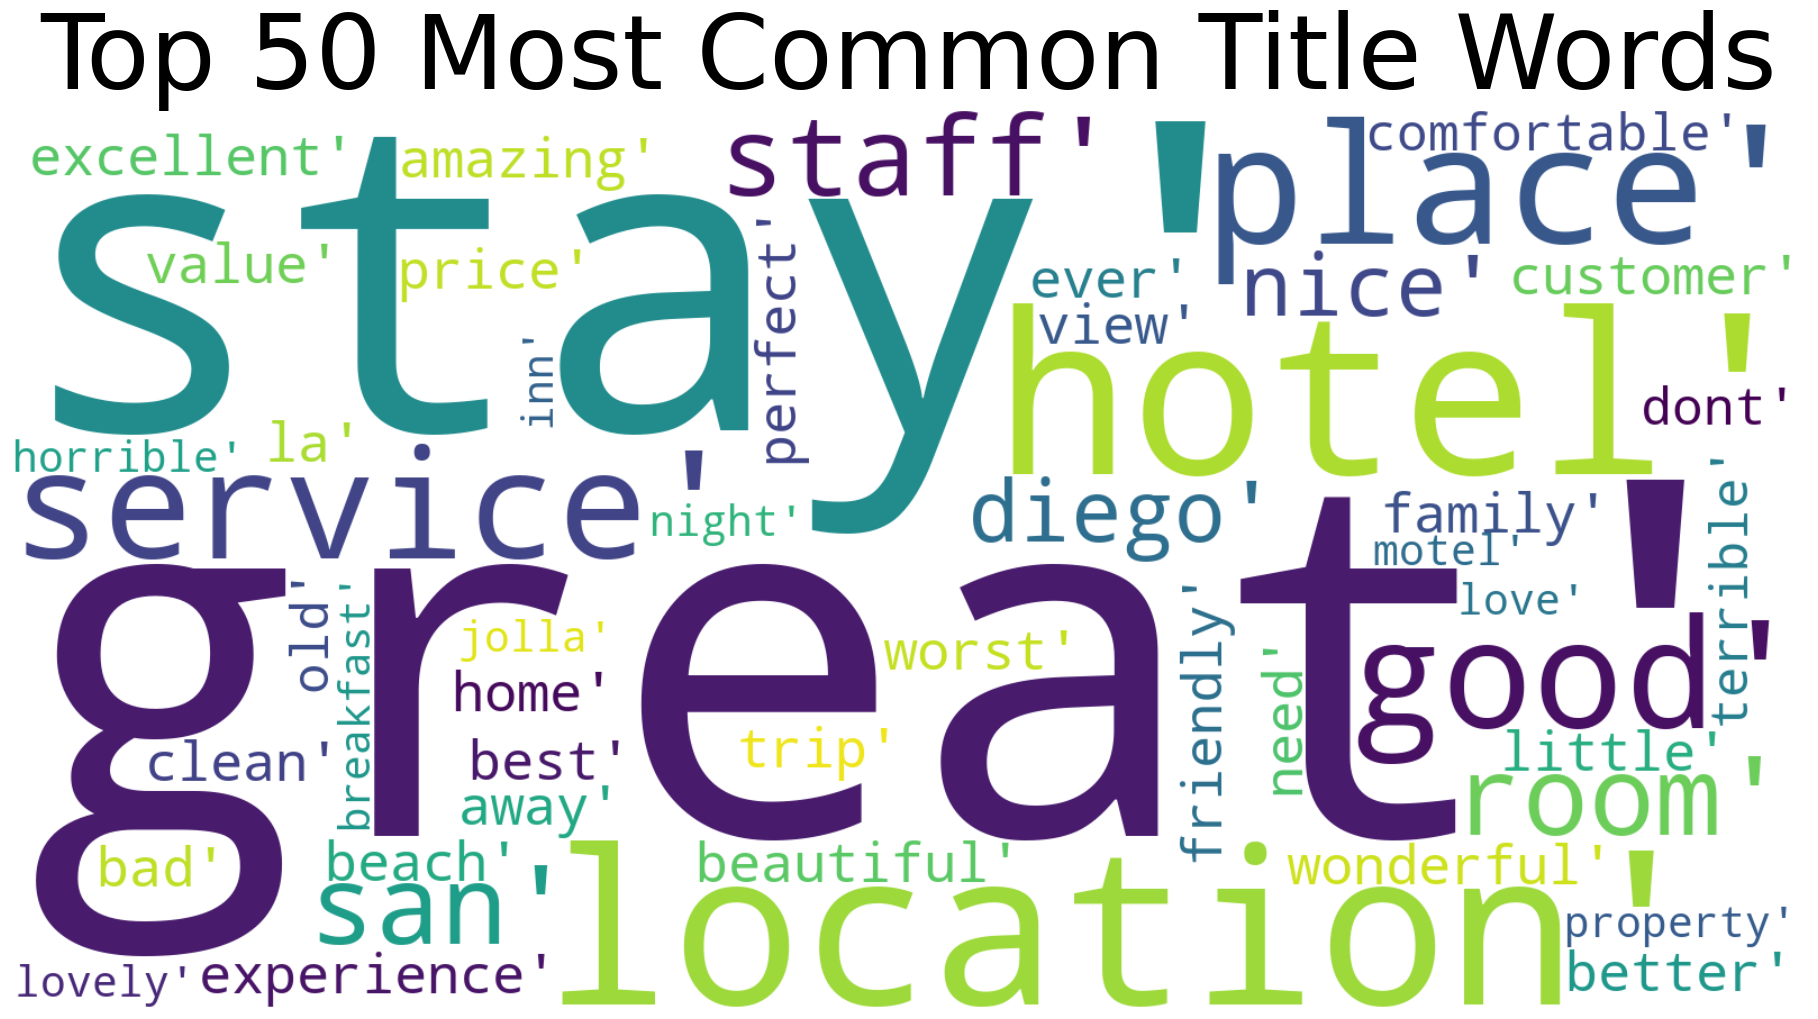

In [17]:
mode = FreqDist(total_words).most_common(50)

cloud = WordCloud(width=1600, height = 800, background_color = 'white').generate(str(mode))

fig = plt.figure(figsize=(30, 10), facecolor='white')
plt.imshow(cloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Title Words', fontsize = 75)
plt.tight_layout(pad=0)
plt.show()


### Hotel Review Summaries

In [18]:

title_words = hotels_df["summary_lemma"]

total_words = []

for x in title_words:
    total_words = total_words + x
    

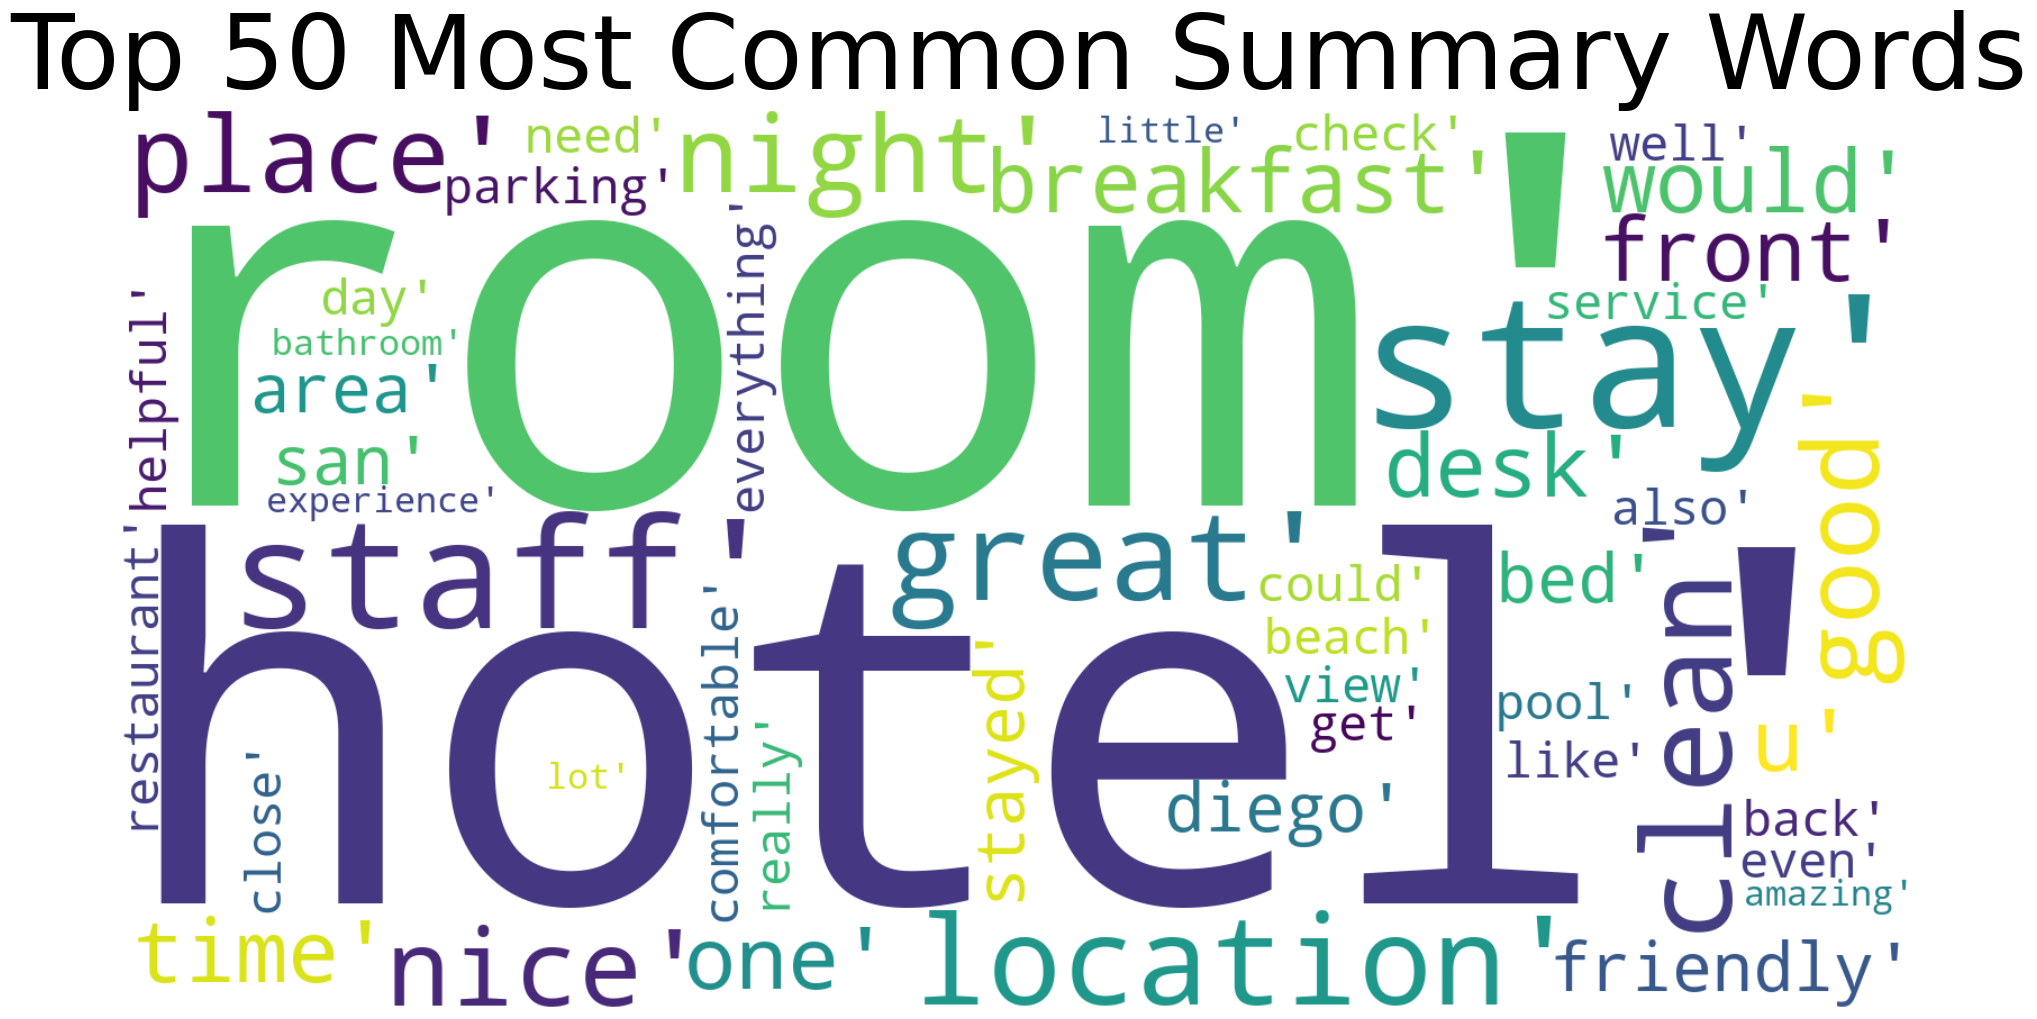

In [19]:

mode = FreqDist(total_words).most_common(50)

cloud = WordCloud(width=1600, height = 800, background_color = 'white').generate(str(mode))

fig = plt.figure(figsize=(30, 10), facecolor='white')
plt.imshow(cloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Summary Words', fontsize = 75)
plt.tight_layout(pad=0)
plt.show()


## Training & Testing Split

In [20]:
#reassigning ratings 

hotels_df.loc[(hotels_df['ratings'] >= 4.5), 'score'] = 5
hotels_df.loc[(hotels_df['ratings'] >= 4) & (hotels_df['ratings'] < 4.5), 'score'] = 4
hotels_df.loc[(hotels_df['ratings'] >= 3) & (hotels_df['ratings'] < 4), 'score'] = 3
hotels_df.loc[(hotels_df['ratings'] >= 2) & (hotels_df['ratings'] < 3), 'score'] = 2
hotels_df.loc[(hotels_df['ratings'] < 2), 'score'] = 1

In [21]:
hotels_df.head(3)

,names,num_reviews,ratings,review_title,review_rating,review_summary,title_tokens,summary_tokens,title_lemma,summary_lemma,title_lemma_str,summary_lemma_str,title_sentiment,summary_sentiment,score
0,Bahia Resort Hotel,6370,4.5,"['Great stay!', 'Outstanding large boutique re...","[4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, ...",['We had a great stay at the Bahia Resort in S...,"[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...","[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...",great stay outstanding large boutique resort g...,great stay bahia resort san diego ben front de...,0.506494,0.281789,5.0
1,Manchester Grand Hyatt San Diego,12646,4.5,"['Excellent hotel', 'Great Stay Near Conventio...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",['The price is very reasonable and the view fr...,"[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...","[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...",excellent hotel great stay near convention cen...,price reasonable view window great easy fast c...,0.673333,0.407880,5.0
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5,"['Great location near Seaport Village, USS Mid...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...","['Great location near Seaport Village, USS Mid...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, us, ...","[great, location, near, seaport, village, us, ...",great location near seaport village us midway ...,great location near seaport village us midway ...,0.543056,0.404851,5.0


In [22]:
from sklearn.model_selection import train_test_split

X = hotels_df['title_lemma_str']
y = hotels_df['score']
y = y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


## Model Training

### Classification Models

In [33]:
tfidf = TfidfVectorizer()

tf1 = tfidf.fit_transform(hotels_df['title_lemma_str'].values.astype('U'))


SVC = LinearSVC(random_state=42)

from sklearn.pipeline import make_pipeline

#### Support Vector Machine

In [24]:
#pipe for the SVC Prediction
pipe = make_pipeline(tfidf,SVC)
pipe.fit(list(X_train),list(y_train))

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('linearsvc', LinearSVC(random_state=42))])

#### Random Forest Classifier

In [25]:
#pip for Random Forest
RFC = RandomForestClassifier()

pipe_2 = make_pipeline(tfidf, RFC)

pipe_2.fit(list(X_train),list(y_train))

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier', RandomForestClassifier())])

#### Naive Bayes Classifier

In [26]:
NB = MultinomialNB()

pipe_3 = make_pipeline(tfidf, NB)

pipe_3.fit(list(X_train),list(y_train))


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

### Topic Models

#### LDA

In [37]:

lda_model = LatentDirichletAllocation(n_components=3, learning_method='online', max_iter=500, random_state=0).fit(tf1)


pipe_4 = make_pipeline(tfidf, lda_model)

pipe_4.fit(list(X_train),list(y_train))



Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('latentdirichletallocation',
                 LatentDirichletAllocation(learning_method='online',
                                           max_iter=500, n_components=3,
                                           random_state=0))])

#### NMF

In [38]:
nmf_model = NMF(n_components=3, random_state=0,init='nndsvd').fit(tf1)

pipe_5 = make_pipeline(tfidf, nmf_model)

pipe_5.fit(list(X_train),list(y_train))

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('nmf', NMF(init='nndsvd', n_components=3, random_state=0))])

## Model Evaluation

### For Classification Models

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [28]:
SVC_predicted = pipe.predict(list(X_test))
print(metrics.classification_report(list(y_test), SVC_predicted))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.35      0.47      0.40        15
           4       0.20      0.20      0.20        15
           5       0.76      0.66      0.70        29

    accuracy                           0.48        60
   macro avg       0.33      0.33      0.33        60
weighted avg       0.50      0.48      0.49        60



C:\Users\nelso\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\nelso\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\nelso\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [29]:
RFC_predicted = pipe_2.predict(list(X_test))
print(metrics.classification_report(list(y_test), RFC_predicted))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.50      0.40      0.44        15
           4       0.33      0.47      0.39        15
           5       0.74      0.69      0.71        29

    accuracy                           0.55        60
   macro avg       0.39      0.39      0.39        60
weighted avg       0.57      0.55      0.55        60



C:\Users\nelso\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\nelso\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\nelso\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [30]:
NB_predicted = pipe_3.predict(list(X_test))
print(metrics.classification_report(list(y_test), NB_predicted))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.75      0.20      0.32        15
           4       0.39      0.47      0.42        15
           5       0.66      0.86      0.75        29

    accuracy                           0.58        60
   macro avg       0.45      0.38      0.37        60
weighted avg       0.60      0.58      0.55        60



C:\Users\nelso\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\nelso\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\nelso\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### For Topic Models

In [48]:


nmf_values = nmf_model.transform(tf1)
hotels_df['nmf_values'] = nmf_values.argmax(axis=1)
lda_values = lda_model.transform(tf1)
hotels_df['lda_values'] = lda_values.argmax(axis=1)
lda_map = {0: 'Poor', 1: 'Moderate', 2: 'Good'}
hotels_df['lda_values'] = hotels_df['lda_values'].map(lda_map)
nmf_map = {0: 'Poor', 1: 'Moderate', 2: 'Good'}
hotels_df['nmf_topics'] = hotels_df['nmf_topics'].map(nmf_map)



ValueError: X has 1930 features, but NMF is expecting 1673 features as input.